In [1]:
# Import necessary libraries
import pandas as pd
import requests
import json
import influxdb_client
from influxdb import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#AUTOMATION AREA
# 1) Get company tickers to format URL string
# 2) Format string as such: "https://financialmodelingprep.com/api/v3/income-statement/" + companyName + "?datatype=csv&apikey=" + API_KEY

In [3]:
# Retrieve local API key from file (---this file is not to be pushed to GitHub for security reasons ---)
keyFile="/home/wintergreen/Projects/fskeyfile.txt"
with open(keyFile) as f:
    key = str(f.readline().replace("\n",""))
API_KEY = key

In [4]:
TICKER_TARGET = "AAPL"

In [5]:
URL = "https://financialmodelingprep.com/api/v3/income-statement/" + TICKER_TARGET + "?limit=120&apikey=" + API_KEY

In [6]:
# Make request for data
r = requests.get(URL)

In [7]:
r = r.json()

In [31]:
# Prepare the data
print(pd.DataFrame.from_dict(r))
data = ((pd.DataFrame.from_dict(r)).sort_values(by=['fillingDate'])).reset_index()

# Combine SellingAndMarketing and generalAndAdministrative into one SGA Cost
data['SellingGeneralAdministrative'] = data.apply(lambda row: row.generalAndAdministrativeExpenses + (row.sellingAndMarketingExpenses), axis=1)

data['SGA_%_GP'] = data.apply(lambda row: row.SellingGeneralAdministrative / (row.grossProfit)*100, axis=1)
data['RD_%_GP'] = data.apply(lambda row: row.researchAndDevelopmentExpenses / (row.grossProfit)*100, axis=1)


# Gather metrics needed for linear time-series graphs
revGrossNet=data[['fillingDate','revenue','grossProfit','netIncome']]

SGA_RD_GP = data[['fillingDate','SGA_%_GP','RD_%_GP']]

          date symbol          fillingDate         acceptedDate period  \
0   2020-09-26   AAPL           2020-10-30  2020-10-29 18:06:25     FY   
1   2019-09-28   AAPL  2019-10-31 00:00:00  2019-10-30 18:12:36     FY   
2   2018-09-29   AAPL  2018-11-05 00:00:00  2018-11-05 08:01:40     FY   
3   2017-09-30   AAPL  2017-11-03 00:00:00  2017-11-03 08:01:37     FY   
4   2016-09-24   AAPL  2016-10-26 00:00:00  2016-10-26 16:42:16     FY   
5   2015-09-26   AAPL  2015-10-28 00:00:00  2015-10-28 16:31:09     FY   
6   2014-09-27   AAPL  2014-10-27 00:00:00  2014-10-27 17:11:55     FY   
7   2013-09-28   AAPL  2013-10-30 00:00:00  2013-10-29 20:38:28     FY   
8   2012-09-29   AAPL  2012-10-31 00:00:00  2012-10-31 17:07:19     FY   
9   2011-09-24   AAPL  2011-10-26 00:00:00  2011-10-26 16:35:25     FY   
10  2010-09-25   AAPL  2010-10-27 00:00:00  2010-10-27 16:36:21     FY   
11  2009-09-26   AAPL  2009-10-27 00:00:00  2009-10-27 16:18:29     FY   
12  2008-09-27   AAPL  2008-11-05 00:0

AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755)


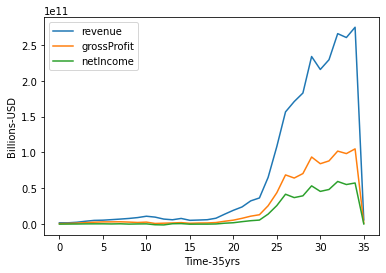

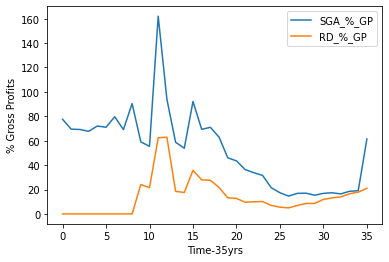

In [32]:
# Plot the data
#plt.figure()
rgnPlot = revGrossNet.plot()
rgnPlot.set_ylabel('Billions-USD')
rgnPlot.set_xlabel('Time-35yrs')

sgardPlot = SGA_RD_GP.plot()
sgardPlot.set_ylabel('% Gross Profits')
sgardPlot.set_xlabel('Time-35yrs')

print(rgnPlot, sgardPlot)

### NEXT STEPS:

At this point, the program can successfully write out data to the InfluxDB database. The next steps will be:

1) Replace the above code with Python code that can write in bulk to the InfluxDB bucket
        
2) Connect the InfluxDB bucket to a Grafana Data Source and create a Dashboard that features this bucket as a DataSource

Once the above two are done, we can then move onto actually plugging data into the InfluxDB.

3) Run calculations on financial data imported into InfluxDB

4) Visualize in Grafana